# 1. k-Nearest-Neighbors and Naive Bayes

In [20]:
from sklearn.datasets import fetch_rcv1
import numpy as np
import pandas as pd
import argparse
from pprint import pprint

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [2]:
def load_labels(path_to_labels):
    labels = pd.read_csv(path_to_labels, names=['label'], dtype=np.int32)
    return labels['label'].tolist()


def load_training_data():
    data = fetch_rcv1(subset='train')
    return data.data, data.target.toarray(), data.sample_id


def load_validation_data(path_to_ids):
    data = fetch_rcv1(subset='test')
    ids = pd.read_csv(path_to_ids, names=['id'], dtype=np.int32)
    mask = np.isin(data.sample_id, ids['id'])
    validation_data = data.data[mask]
    validation_target = data.target[mask].toarray()
    validation_ids = data.sample_id[mask]
    return validation_data, validation_target, validation_ids

labels = load_labels("labels.txt")
train_data, train_target, _ = load_training_data()
eval_data, eval_target, _ = load_validation_data("validation.txt")

limit = 1000

## 1a. & 1b.

In [3]:
class CS5304BaseClassifier(object):
    def __init__(self):
        pass

    def train(self, x, y):
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError


class CS5304KNNClassifier(CS5304BaseClassifier):
    """
    http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    """

    def __init__(self, n_neighbors=5):
        super(CS5304KNNClassifier, self).__init__()
        self.n_neighbors = n_neighbors
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)


class CS5304NBClassifier(CS5304BaseClassifier):
    """
    http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
    """

    def __init__(self):
        super(CS5304NBClassifier, self).__init__()
        self.model = BernoulliNB()

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

## Find Best K for KNN
The following codes show how to find best K for each label in KNN and output the max average accuracy for each label

In [18]:
def findBestKNN(X, Y, label):
    max_ave_accuracy = 0
    best_k = 0
    for k in range(2, 40):
        model = KNeighborsClassifier(n_neighbors=k)
        ave_accuracy = np.mean(cross_val_score(model, X, Y[:,label],cv=5))
        if max_ave_accuracy < ave_accuracy:
            max_ave_accuracy = ave_accuracy
            best_k = k
    print("max average accuracy for label",label, "is:", max_ave_accuracy)
    return [best_k,max_ave_accuracy]

selected_labels = [4,5,7,33,59,70,83,95,98,102]
best_k_for_each_label = np.array([findBestKNN(train_data[:limit], train_target[:limit], l) for l in selected_labels])
print("\nBest K for each selected label is:\n", best_k_for_each_label[:,0])


max average accuracy for label 4 is: 0.93
max average accuracy for label 5 is: 0.945084377109
max average accuracy for label 7 is: 0.947018950474
max average accuracy for label 33 is: 0.833802770069
max average accuracy for label 59 is: 0.900943923598
max average accuracy for label 70 is: 0.883053926348
max average accuracy for label 83 is: 0.951964574114
max average accuracy for label 95 is: 0.955019050476
max average accuracy for label 98 is: 0.967004425111
max average accuracy for label 102 is: 0.914984274607

Best K for each selected label is:
 [ 29.  38.   6.  24.  19.   5.   8.  16.  11.  20.]


The following codes use BernoulliNB to predict the selected labels and output the corresponding accuracy

In [11]:
NB_ave_accuracy_each_label = np.array([np.mean(cross_val_score(BernoulliNB(), train_data, train_target[:,l],cv=5)) for l in selected_labels])
print("For each label, the accuracy would be:\n")
pprint(NB_ave_accuracy_each_label)

For each label, the accuracy would be:

array([ 0.80755136,  0.90332185,  0.92708098,  0.7894944 ,  0.90301972,
        0.90915376,  0.90172223,  0.95477138,  0.97321708,  0.90470603])


## 1c. Data Analysis

From the graph below, one can see that label 33 is the most difficult label to classify.

The reason why KNN and BernoulliNB perform worst for label 33 is that:

The number of entries of label 33 that are `1` takes 46.59% of the total entries, which is the highest one in the ten selected labels. Besides, according to the 2d scatter of the data points of label 33, train data are quite mixed based on label 33. These two characteristics make it difficult for KNN and BernoulliNB to classify label 33.


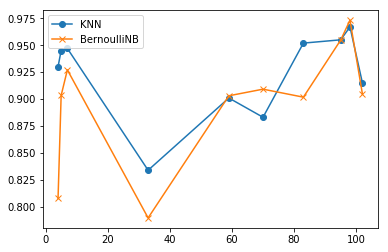

In [19]:
plt.plot(selected_labels,best_k_for_each_label[:,1],marker='o')
plt.plot(selected_labels,NB_ave_accuracy_each_label,marker='x')
plt.legend(['KNN','BernoulliNB'])
plt.show()

# 2. K-Means
## 2a.

In [21]:
class CS5304KMeansClassifier(CS5304BaseClassifier):
    
    def __init__(self, n_clusters=2, init='k-means++', n_init = 10):
        super(CS5304KMeansClassifier, self).__init__()
        self.n_clusters = n_clusters
        self.n_init = n_init
    
    def train(self, X, y):
        self.centroids = self.getCentroids(X, y)
        self.model = KMeans(n_clusters = self.n_clusters, init = self.centroids, n_init = self.n_init)
        self.model.fit(X)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def getCentroids(self, X, y):
        trueSet = [i for i, j in enumerate(y) if j == 1]
        falseSet = [i for i, j in enumerate(y) if j == 0]
        trueCentroid = X[trueSet].mean(axis=0)
        falseCentroid = X[falseSet].mean(axis=0)
        return np.concatenate((falseCentroid, trueCentroid), axis=0)

## Train KMeans classifiers for each selected label

In [24]:
kmeans_first_ten_label_classifiers = [CS5304KMeansClassifier() for i in range(len(selected_labels))]
for i in range(len(selected_labels)):
    kmeans_first_ten_label_classifiers[i].train(train_data, train_target[:, selected_labels[i]])

/Users/mlx/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


## 2b.

In [27]:
def visualize(cluster, data, target, legends):
    '''
    This function can take in data points that are from different clusters
    and present them in a graph
    :param cluster: the number of different clusters
    :param data: the input data (2 dimensional)
    :param target: the label of each entry in data
    :param legends:
    :return:
    '''
    centroids = []
    for k in range(cluster):
        indice = [i for i,j in enumerate(target) if j == k]
        points = data[indice]
        centroids.append(points.mean(axis=0))
        plt.scatter(points[:,0],points[:,1])
        
    for centroid in centroids:
        plt.scatter(centroid[0],centroid[1],marker='x')
        
    plt.legend(legends)
    plt.show()
    

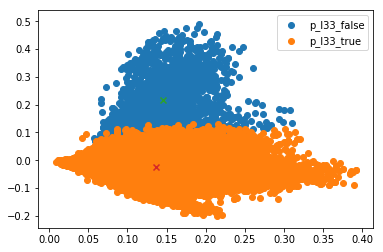

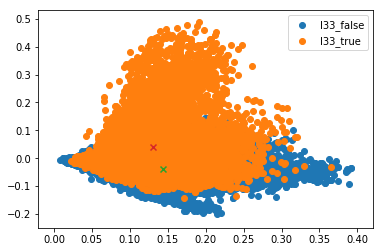

In [28]:
prediction_result_on_label33 = np.array(kmeans_first_ten_label_classifiers[3].predict(train_data))
train_data_dimension_reducted = TruncatedSVD(n_components = 2).fit_transform(train_data)

# This line visualize the predictions from KMeans for label 33 with a 2-dimensional plot
visualize(2, train_data_dimension_reducted, prediction_result_on_label33,['p_l33_false','p_l33_true'])

# This line visualize the data distribution provided label 33 with a 2-dimensional plot
visualize(2, train_data_dimension_reducted, train_target[:,33],['l33_false','l33_true'])

## 2c.

No, the clusters do not look similar as when you provided the labels.

According to the visualization graph of the data distribution provided label 33, we can find that the train data points are quite mixed on label3. They have a large area of overlapping.

But when we try to used KMeans to cluster the train data into two cluster, the data points that is nearer to one centroid would be classified into that cluster. This is true for two centroids. So there would be no overlapping area in the prediction graph because all data points would only belong to one cluster. That is why one can observe clear borderline between two clusters.

When using 3 or 4 clusters instead of 2, one can see more clusters, clear borderlines and centroids. But still, there exists no overlapping area in the graph.




In [264]:
KMeans_label_33_2cluster = KMeans(n_clusters = 2, init='random').fit(train_data)
KMeans_label_33_3cluster = KMeans(n_clusters = 3, init='random').fit(train_data)
KMeans_label_33_4cluster = KMeans(n_clusters = 4, init='random').fit(train_data)

two_cluster_prediction = KMeans_label_33_2cluster.predict(train_data)
three_cluster_prediction = KMeans_label_33_3cluster.predict(train_data)
four_cluster_prediction = KMeans_label_33_4cluster.predict(train_data)


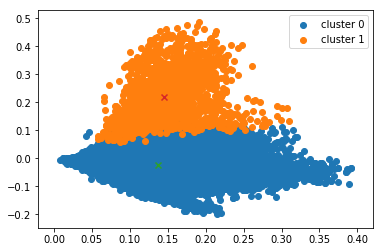

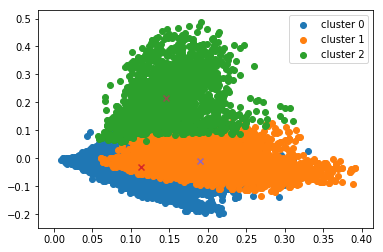

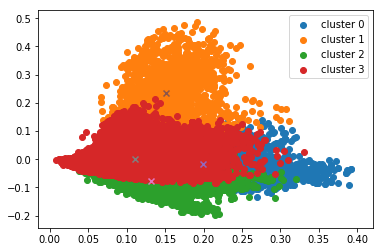

In [284]:
visualize(2, train_data_dimension_reducted, two_cluster_prediction,['cluster 0','cluster 1'])
visualize(3, train_data_dimension_reducted, three_cluster_prediction, ['cluster 0','cluster 1','cluster 2'])
visualize(4, train_data_dimension_reducted, four_cluster_prediction, ['cluster 0','cluster 1','cluster 2', 'cluster 3'])